# Saria México

Neste notebook será aplicado o modelo Sarima, ou Arima considerando a sazonalidade, que vai ser aplicado nos casos de morte por Covid no Equador.

In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20M%C3%A9xico.csv'
serie_mex = pd.read_csv(url)
serie_mex.drop('Unnamed: 0',axis=1,inplace=True)
serie_mex['Date'] = pd.to_datetime(serie_mex['Date'],format='%Y-%m-%d')
serie_mex['Mês'] = serie_mex['Date'].dt.month
serie_mex.set_index('Date',inplace=True)
serie_mex.head()


,Confirmed,Recovered,Deaths,Ano,Mês
Date,,,,,
2020-01-22,0,0.0,0,2020,1
2020-01-23,0,0.0,0,2020,1
2020-01-24,0,0.0,0,2020,1
2020-01-25,0,0.0,0,2020,1
2020-01-26,0,0.0,0,2020,1


In [ ]:
# Separação entre treino e teste
treino = serie_mex[(serie_mex['Ano']<=2021)&(serie_mex['Mês']<12)]
teste = serie_mex[(serie_mex['Ano']==2021)&(serie_mex['Mês'] == 12)]

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 0, 1)",12.000000
1,"(2, 1, 1, 2)",14.000000
2,"(2, 2, 0, 2)",14.000000
3,"(3, 3, 0, 2)",18.000000
4,"(2, 3, 0, 3)",18.000000
...,...,...
248,"(0, 0, 0, 0)",10931.366495
249,"(1, 0, 0, 0)",10933.241624
250,"(0, 1, 0, 0)",10933.243588
251,"(2, 0, 0, 0)",10934.173231


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(1, 2, 1), seasonal_order=(1, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 Deaths   No. Observations:                  648
Model:             SARIMAX(1, 2, 1)x(1, 1, [1, 2], 4)   Log Likelihood               -5260.104
Date:                                Fri, 16 Dec 2022   AIC                          10532.208
Time:                                        01:25:46   BIC                          10558.996
Sample:                                             0   HQIC                         10542.604
                                                - 648                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0368      0.061     -0.599      0.549      -0.157       0.084
ma.

In [ ]:
fc = best_model.forecast(31, alpha=0.05)

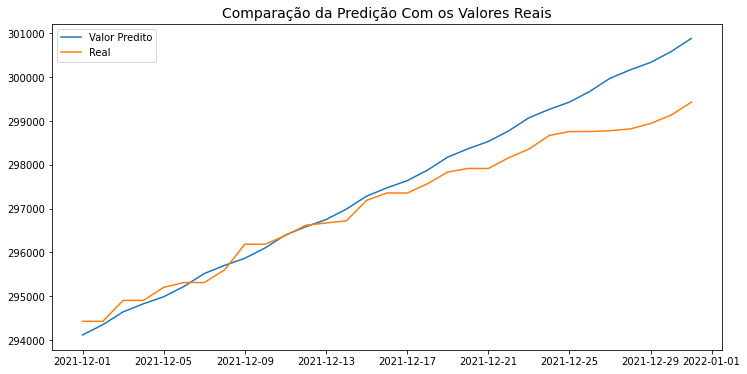

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.0015905459136547864
MAE: 474.308079440218
RMSE: 655.345715169987
